In [2]:
import sys
sys.path.append('../Utils/')

from IOUtils_v1 import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from datetime import date
import re
import quandl   
# Necessary for obtaining financial data easily
import datetime as dt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def ternary (n, l):
    if n == 0:
        return '0'*l
    nums = []
    while n:
        n, r = divmod(n, 3)
        nums.append(str(r))
    return ('0'*(l-len(nums))) + ''.join(reversed(nums))

def sequence_freq(tick_sequence, n):
    sequence_dict = {ternary(k, n): len(re.findall(r"(?={0})".format(ternary(k, n)), tick_sequence)) for k in range(3**n)}
    sequence_freq = pd.DataFrame(list(sequence_dict.items()), columns = ['sequence', 'freq'])
    sequence_freq['prior'] = sequence_freq['sequence'].str.slice(0, n-1)
    sequence_freq['move'] = sequence_freq['sequence'].str.slice(n-1, n)
    sequence_freq = sequence_freq.pivot(index = 'prior', columns = 'move', values = 'freq')
    sequence_freq['total'] = sequence_freq['0'] + sequence_freq['1'] + sequence_freq['2']
    sequence_freq['max'] = sequence_freq.loc[:, '0':'2'].idxmax(axis = 1)
    sequence_freq['max_pct'] = sequence_freq.loc[:, '0':'2'].max(axis = 1)/sequence_freq['total']
    sequence_freq['prior'] = 'p'+sequence_freq.index.map(str)
    return sequence_freq

In [3]:
class movingaveragestrategy(object):
    def __init__(self, data, short_window=5, long_window=20):
        self.data = deepcopy(data)  #original data set is not changed so that we can always go back
        self.short_window = short_window
        self.long_window = long_window
 
    def generatingsignal(self):
        self.data['signal'] = 0 #initiate all signal position to 0
        #self.data['closeMid'] = (self.data['closeBid'] + self.data['closeAsk']) / 2
        #use the open price to predict the price change and place order before the market closing
        self.data['fastma'] = self.data['Adj. Open'].rolling(window=self.short_window).mean()
        self.data['slowma'] = self.data['Adj. Open'].rolling(window=self.long_window).mean()
        self.data = self.data.dropna()
        self.data['signal'] = np.where(self.data['fastma']>self.data['slowma'], 1, -1)
 
        return self.data

In [4]:
class vectorizedbacktest(object):
    def __init__(self, data, strategy, strategy_params):
        self.data = data # price history data
        self.strategy = strategy(self.data, **strategy_params)
        self.result = 'please run backtest first'
        self.performance = 'please calculate performance first'
 
    def runtest(self):
        self.result = self.strategy.generatingsignal()
        self.result['tradeID'] = (~(self.result['signal']==self.result['signal'].shift(1))).cumsum()
        self.result['return'] = np.log(self.result['Adj. Close']/self.result['Adj. Close'].shift(1))
        self.result['strategy'] = self.result['return'] * self.result['signal']
 
        # This step is to take into account of transaction cost. For every order, return reduced by the spread
        #self.result['strategy'] = np.where(self.result['signal']&lt;&gt;self.result['signal'].shift(1), 
        #self.result['strategy'] - np.log(self.result['closeAsk']/self.result['closeBid']), self.result['strategy'])
 
        return self.result
 
    def calperformance(self):
        self.result['benchmark'] = self.result['return'].cumsum() + 1
        self.result['equitycurve'] = self.result['strategy'].cumsum() + 1
        self.result['drawdown'] = self.result['equitycurve']/(self.result['equitycurve'].expanding().max())-1
        drawdown_max = self.result['drawdown'].min()
        # regroup to calculate daily return, this is used to calculate the annualized std and sharpe ratio
        daily_returns = self.result['strategy'].groupby(self.result.index.normalize())
        daily_bm_returns = self.result['return'].groupby(self.result.index.normalize())
        #daily_excess_returns = daily_returns - daily_bm_returns
        self.daily_return = daily_returns.aggregate(np.sum)
        vol = self.daily_return.std() * ((250)**0.5)
        average_daily_return = self.daily_return.mean()
        total_return = self.result['equitycurve'][-1]-1
        sharpe = (average_daily_return * 250)/ vol
        
        #average_daily_excess_return = daily_exess_return.mean()
        #excess_vol = daily_excess_return.std() * ((250)**0.5)
        #ir = (average_daily_excess_return * 250)/ excess_vol
        # trade analysis
        trades = self.result[['strategy', 'tradeID']].groupby('tradeID')
        self.trade = trades.aggregate(np.sum)
        total_count = self.trade['strategy'].count()
        positive_count = (self.trade['strategy'][self.trade['strategy']>0]).count()
        winning_rate = positive_count/total_count
        #negative_count = (self.trade['strategy'][self.trade['strategy']&lt;0]).count() winning_rate = float(positive_count) / total_count average_positive_return = (self.trade['strategy'][self.trade['strategy']&gt;0]).mean()
        average_negative_return = (self.trade['strategy'][self.trade['strategy']<0]).mean()
        average_positive_return = (self.trade['strategy'][self.trade['strategy']>0]).mean()
        profit_factor = - average_positive_return / average_negative_return
        average_return = self.trade['strategy'].mean()
        max_trade = self.trade['strategy'].max()
        min_trade = self.trade['strategy'].min()
 
        # store trade metrics
        self.performance = {'Total Number of Trades': total_count, 
        'Winning Rate': winning_rate, 
        'Profit Factor': profit_factor, 
        'Average Return per Trade': average_return, 
        'Average Positive Return': average_positive_return, 
        'Average Negative Return': average_negative_return, 
        'Max Drawdown': drawdown_max, 
        'Total Return': total_return, 
        'Annualized Volatility': vol, 
        'Sharpe Ratio': sharpe, 
        #'Information Ratio':ir,
        'Largest Winning Trade': max_trade, 
        'Largest Losing Trade': min_trade}

In [6]:
import csv
from copy import deepcopy
 
# import data and drop irrelevant columns
test_bars = pd.HDFStore('MSFT' + '.h5', 'r')
df = test_bars['data']
test_bars.close()
data = df[['Adj. Open', 'Adj. Close']]
"""
df['closeMid'] = (df['closeBid']+df['closeAsk'])/2
data = df[['closeBid', 'closeAsk', 'closeMid']]
"""
 
strategy_params = {'short_window':1, 'long_window':5}
test = vectorizedbacktest(data, movingaveragestrategy, strategy_params)
test.runtest()
test.calperformance()
test.performance


{'Annualized Volatility': 0.34064209905200543,
 'Average Negative Return': -0.01647256032972221,
 'Average Positive Return': 0.03395393799588502,
 'Average Return per Trade': 0.008429477809382758,
 'Largest Losing Trade': -0.11807719656452137,
 'Largest Winning Trade': 0.40021575222204242,
 'Max Drawdown': -0.46483798607417548,
 'Profit Factor': 2.061242291195033,
 'Sharpe Ratio': 1.6419010118128887,
 'Total Number of Trades': 2141,
 'Total Return': 10664813.567574654,
 'Winning Rate': 0.492760392340028}

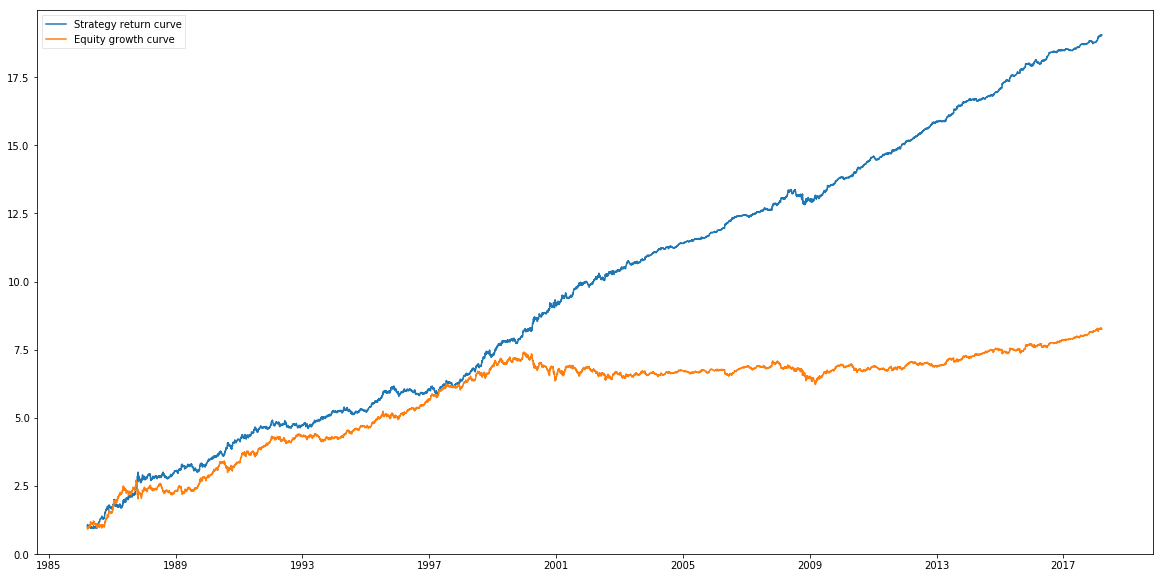

In [8]:
plt.figure(figsize=(20,10))
plt.plot(test.result['equitycurve'], label = "Strategy return curve")
plt.plot(test.result['benchmark'], label = 'Equity growth curve')

leg = plt.legend(loc='best', ncol=1, shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.5)
plt.show()


In [17]:
# Optimization
shortls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 55]
longls = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
 
# init return benchmark and results file format
benchmark = 0.
column_names = ['Total Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 
            'Winning Rate', 'Profit Factor', 'Average Return per Trade', 'Average Positive Return', 
                'Average Negative Return', 'Largest Winning Trade', 'Largest Losing Trade', 'Total Number of Trades']
 
with open('./Output/results.csv','w') as f:
    w = csv.writer(f)
    w.writerow(['short window', 'long window'] + column_names)
 
for i in shortls:
    for j in longls:
        j
        if i + 1 >= j: #trying to hold the position for at least a minute here
            pass
        else:
            strategy_params = {'short_window': i, 'long_window': j}
            test = vectorizedbacktest(data, movingaveragestrategy, strategy_params)
            test.runtest()
            test.calperformance()
            # record backtest result
            with open('./Output/results.csv','a') as f:
                w = csv.writer(f)
                w.writerow([i, j] + [test.performance[key] for key in column_names])
 
            if test.performance['Total Return'] > benchmark:
                optimized = [i, j]
                benchmark = test.performance['Total Return']

In [21]:
print('optimized short-long pair:{0}, optimized performance:{1}'.format(optimized, benchmark))

optimized short-long pair:[1, 3], optimized performance:22.20227693430333
